In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from clean_text import clean_text_pipeline as ctp
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from itertools import combinations
import networkx as nx
import nltk

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\omara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the data

In [5]:
file_path = "arxiv-metadata-oai-snapshot.json"

total_lines = sum(1 for _ in open(file_path, 'r'))

with tqdm(total=total_lines, desc="Reading JSON", unit="line") as pbar:
    data = pd.read_json(file_path, lines=True, chunksize=10000)
    df = pd.concat(chunk for chunk in data)
    pbar.update(total_lines)

Reading JSON: 100%|█████████████████████████████████████████████████████| 2639143/2639143 [01:34<00:00, 27880.35line/s]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639143 entries, 0 to 2639142
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   submitter       object
 2   authors         object
 3   title           object
 4   comments        object
 5   journal-ref     object
 6   doi             object
 7   report-no       object
 8   categories      object
 9   license         object
 10  abstract        object
 11  versions        object
 12  update_date     object
 13  authors_parsed  object
dtypes: object(14)
memory usage: 281.9+ MB


In [8]:
df.loc[:,'categories']

0                              hep-ph
1                       math.CO cs.CG
2                      physics.gen-ph
3                             math.CO
4                     math.CA math.FA
                      ...            
2639138    supr-con cond-mat.supr-con
2639139    supr-con cond-mat.supr-con
2639140    supr-con cond-mat.supr-con
2639141    supr-con cond-mat.supr-con
2639142    supr-con cond-mat.supr-con
Name: categories, Length: 2639143, dtype: object

# Task 1

### 1.

In [281]:
all_categories = [category for sublist in df['categories'].str.split() for category in sublist]

In [283]:
category_counts = pd.Series(all_categories).value_counts()

In [285]:
len(category_counts)

176

I plotted only top 50 categories to make the graph more readable

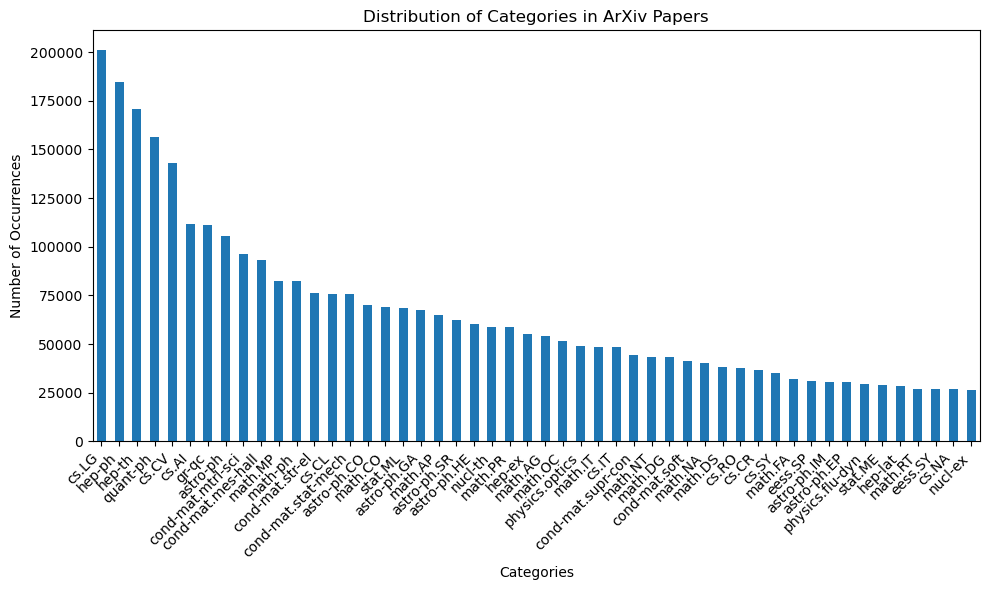

In [16]:
plt.figure(figsize=(10, 6))
category_counts.head(50).plot(kind='bar')
plt.title("Distribution of Categories in ArXiv Papers")
plt.xlabel("Categories")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.

I chose the "cs.AI" category

In [18]:
selected_category = "cs.AI"

In [20]:
filtered_abstracts = df[df['categories'].str.contains(selected_category, regex=False)]['abstract']

In [22]:
text_corpus = " ".join(filtered_abstracts)

In [28]:
text_series = pd.Series([text_corpus])

For cleaning the text I used the cleaning function that you provided us in the labs. I provided the .py file.

In [30]:
clean_text = ctp(text_series)

In [34]:
clean_text = clean_text.iloc[0]

In [40]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(clean_text)

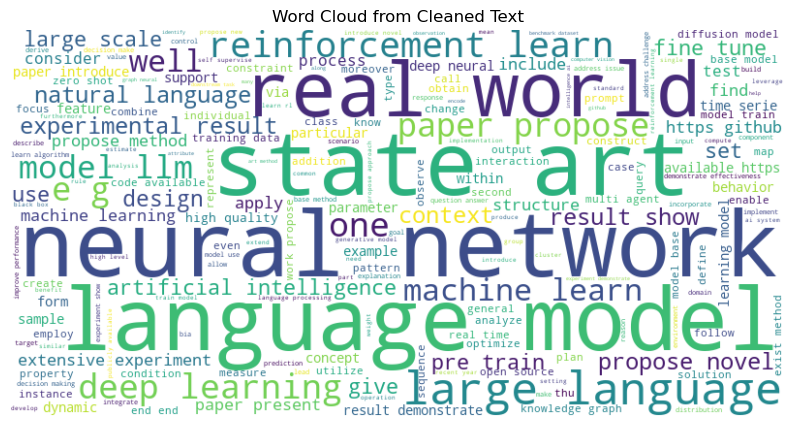

In [42]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from Cleaned Text")
plt.show()

### 3.

In [10]:
categories_split = df['categories'].str.split()
all_categories = [category for sublist in categories_split for category in sublist]
top_categories = pd.Series(all_categories).value_counts().head(5).index

### Lack of text cleaning
I had issues while cleaning the text for this task, because it was taking too long. i left it for 5 hours and then it crashed due to memory usage. So i decided to do it without cleaning the text. I know the results are not interesting because of the lack of cleaning, but I just couldn't spend more time on this because of hardware limitaions and I needed to use my laptop for other projects. I am very sorry.


In [18]:
top_words = {}
for category in top_categories:
    filtered_abstracts = df[df['categories'].str.contains(category, regex=False)]['abstract']
    
    text_corpus = " ".join(filtered_abstracts)
    
    words = text_corpus.split()
    
    word_counts = Counter(words)
    
    top_words[category] = word_counts.most_common(3)

In [20]:
for category, words in top_words.items():
    print(f"Category: {category}")
    for word, count in words:
        print(f"  {word}: {count}")

Category: cs.LG
  the: 1693424
  of: 1095999
  and: 944585
Category: hep-ph
  the: 1829550
  of: 950441
  and: 574181
Category: hep-th
  the: 1634576
  of: 956429
  a: 492434
Category: quant-ph
  the: 1378451
  of: 943597
  a: 568544
Category: cs.CV
  the: 1204678
  and: 744404
  of: 716787


# Task 2
for this task I decided to take 2 random samples of 1000 and 2000 authors respectively, also due to memory limitation because the number of permutations is too big for bigger numbers.

In [227]:
all_authors = set()

for author_list in df['authors_parsed'].dropna():
    flat_author_list = [author[0].strip() for author in author_list if author] 
    all_authors.update(flat_author_list)

### 1000 Authors

In [229]:
import random
random.seed(42) 
selected_authors = set(random.sample(list(all_authors), 1000))

In [231]:
len(selected_authors)

1000

In [233]:
coauthor_edges = []

for author_list in df['authors_parsed'].dropna():
    flat_author_list = [author[0].strip() for author in author_list if author and author[0].strip() in selected_authors]
    coauthor_edges.extend(combinations(flat_author_list, 2))  


In [295]:
G = nx.Graph()
G.add_edges_from(filtered_edges)

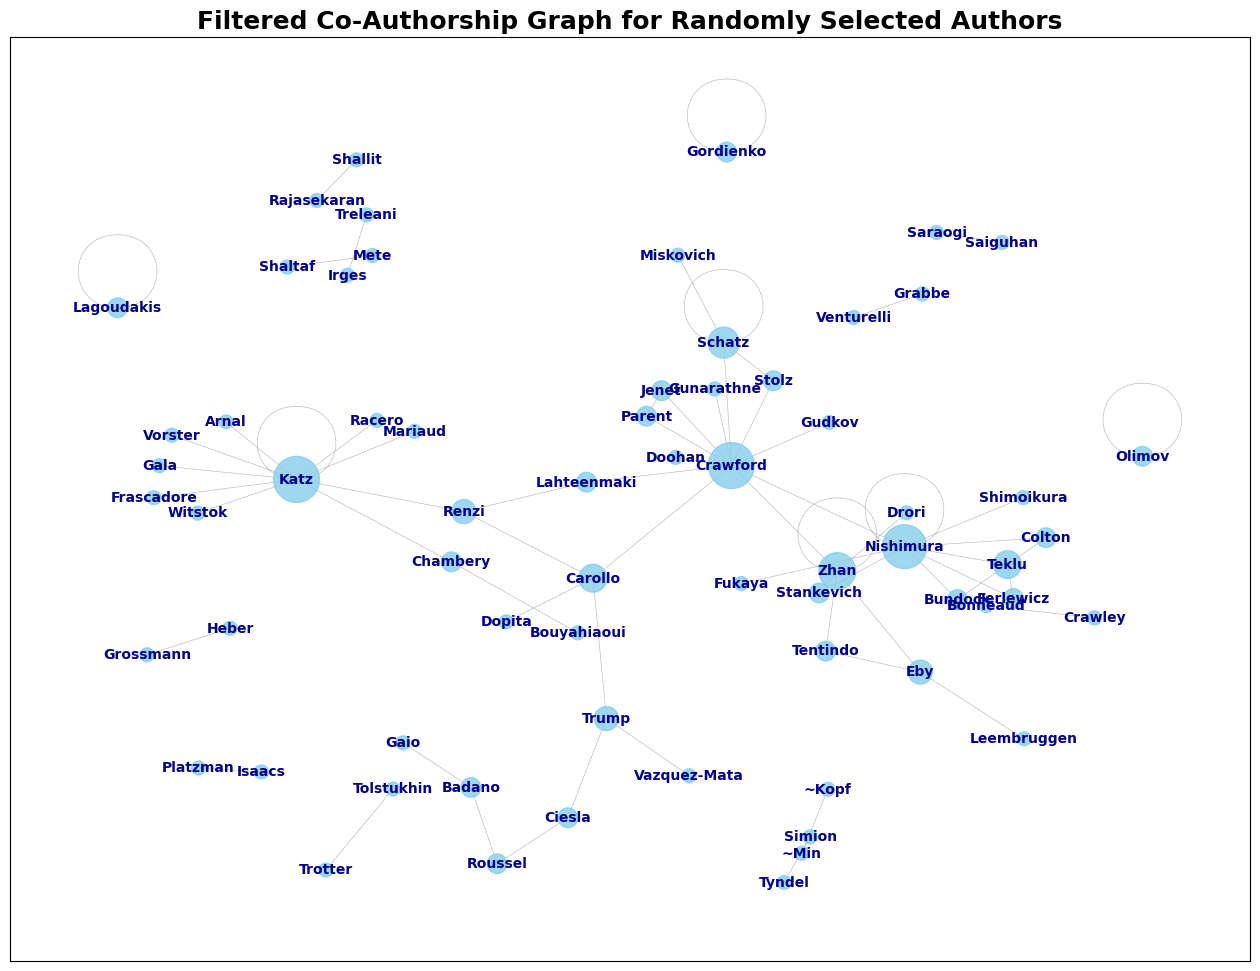

In [297]:
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, seed=42, k=0.3)  
node_sizes = [deg * 100 for _, deg in G.degree()]  
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color="skyblue",
    alpha=0.8,  
)

edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
nx.draw_networkx_edges(
    G,
    pos,
    edge_color="gray",
    alpha=0.5,
    width=[weight * 0.5 for weight in edge_weights],
)

nx.draw_networkx_labels(
    G,
    pos,
    font_size=10, 
    font_color="darkblue",
    font_weight="bold",
)

plt.title(
    "Filtered Co-Authorship Graph for Randomly Selected Authors",
    fontsize=18,
    fontweight="bold",
)
plt.show()

### 2000 Authors

In [263]:
random.seed(42) 
selected_authors = set(random.sample(list(all_authors), 2000))

In [265]:
coauthor_edges = []

for author_list in df['authors_parsed'].dropna():
    flat_author_list = [author[0].strip() for author in author_list if author and author[0].strip() in selected_authors]
    coauthor_edges.extend(combinations(flat_author_list, 2)) 


In [266]:
G = nx.Graph()
G.add_edges_from(coauthor_edges)

Excluding edges with degrees <= 5, which are the authors with less than 5 co-authors to make graph more readable.

In [267]:
min_degree = 5
low_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree < min_degree]
G.remove_nodes_from(low_degree_nodes)

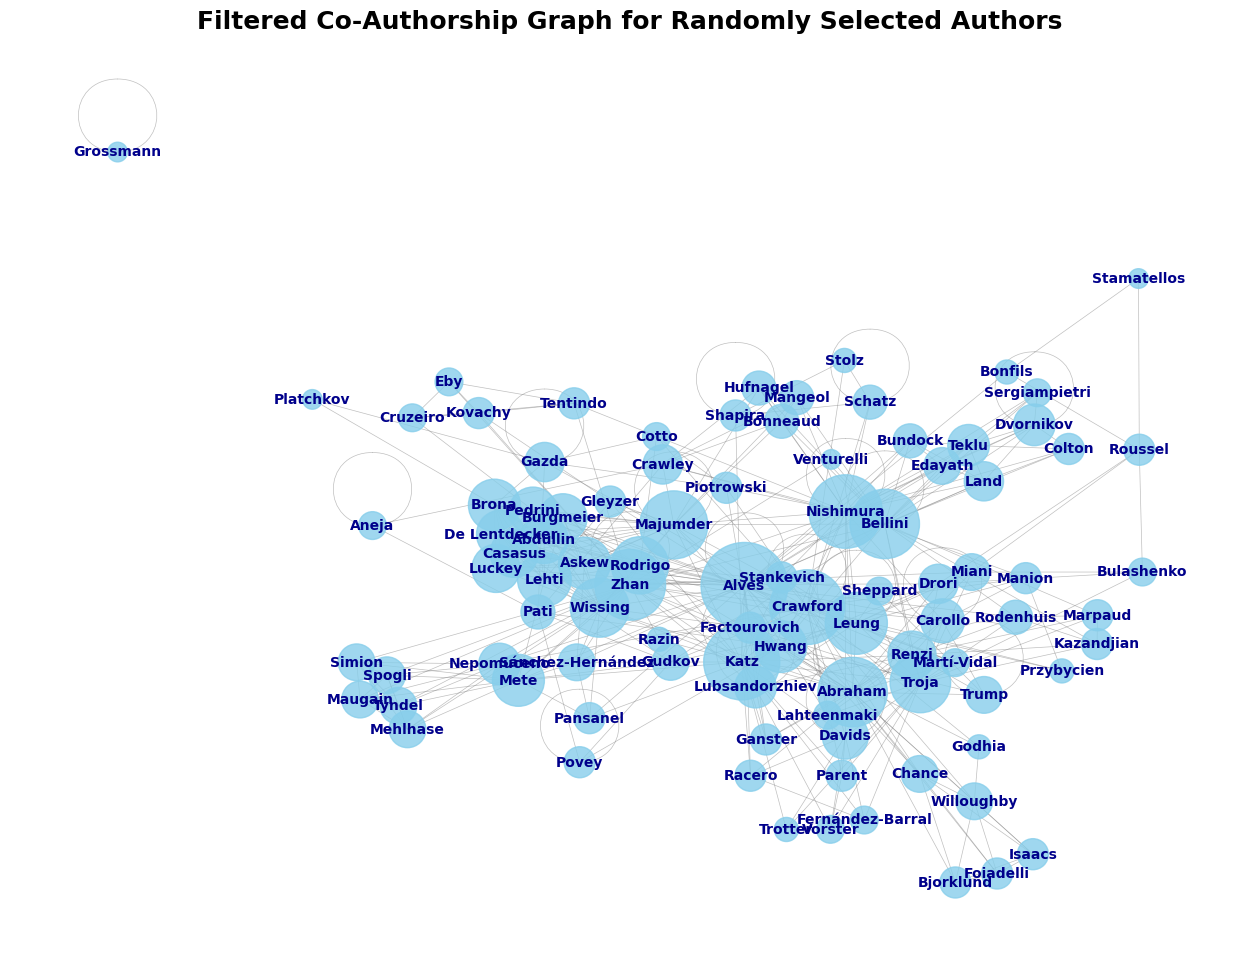

In [268]:
plt.figure(figsize=(16, 12))  
pos = nx.spring_layout(G, seed=42, k=0.3)  

node_sizes = [deg * 100 for _, deg in G.degree()] 
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color="skyblue",
    alpha=0.8, 
)

edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
nx.draw_networkx_edges(
    G,
    pos,
    edge_color="gray",
    alpha=0.5,
    width=[weight * 0.5 for weight in edge_weights],
)

nx.draw_networkx_labels(
    G,
    pos,
    font_size=10,
    font_color="darkblue",
    font_weight="bold",
)

plt.title(
    "Filtered Co-Authorship Graph for Randomly Selected Authors",
    fontsize=18,
    fontweight="bold",
)
plt.axis("off")
plt.show()
